<a href="https://colab.research.google.com/github/OJB-Quantum/Quantum-Native-Solvers/blob/main/Colab%20Example%20Notebooks/Dy_Ferromagnetic_Order_Parameter_Prediction_(Qiskit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [ ]:
# Choose the wheel that matches the CUDA version in the runtime
# -------------------------------------------------------------
# Check the CUDA toolkit that is already installed in the notebook
!nvcc --version   # or `!nvidia-smi` – the “CUDA Version” column

# --- If the output shows CUDA 12.x ---
!pip install -q "qiskit==2.2.*" "qiskit-aer-gpu-cu11==0.17.2" pylatexenc

In [7]:
from qiskit_aer import AerSimulator
import qiskit

# Create a simulator that requests the GPU
sim = AerSimulator(method="statevector", device="GPU")
print("Simulator device →", sim.options.device)   # should print “GPU”

# Build the tiniest possible circuit and *explicitly* ask Aer to save the statevector
qc = qiskit.QuantumCircuit(1)
qc.h(0)
qc.save_statevector()          # <<< this line fixes the “No statevector” error

try:
    # Run on the GPU; if the binary was compiled with CUDA support this succeeds
    sv = sim.run(qc).result().get_statevector()
    print("GPU simulation works! Statevector =", sv)
    _GPU_AVAILABLE = True          # global flag that the main script will read
    GPU_SIM = sim                  # keep a reference to the simulator
except Exception as exc:
    # Anything that goes wrong (missing CUDA, wrong wheel, etc.) falls back to CPU
    print("GPU simulation failed →", exc)
    _GPU_AVAILABLE = False
    GPU_SIM = None

Simulator device → GPU
GPU simulation works! Statevector = Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))



Size-dependent transition temperatures (Dy-like):
 size [nm]   T_transition [K]
     0.35      0.039
     0.56      0.161
     0.80      0.468
     1.00     17.000
     2.00     51.000
     5.00     71.400
    10.00     78.200


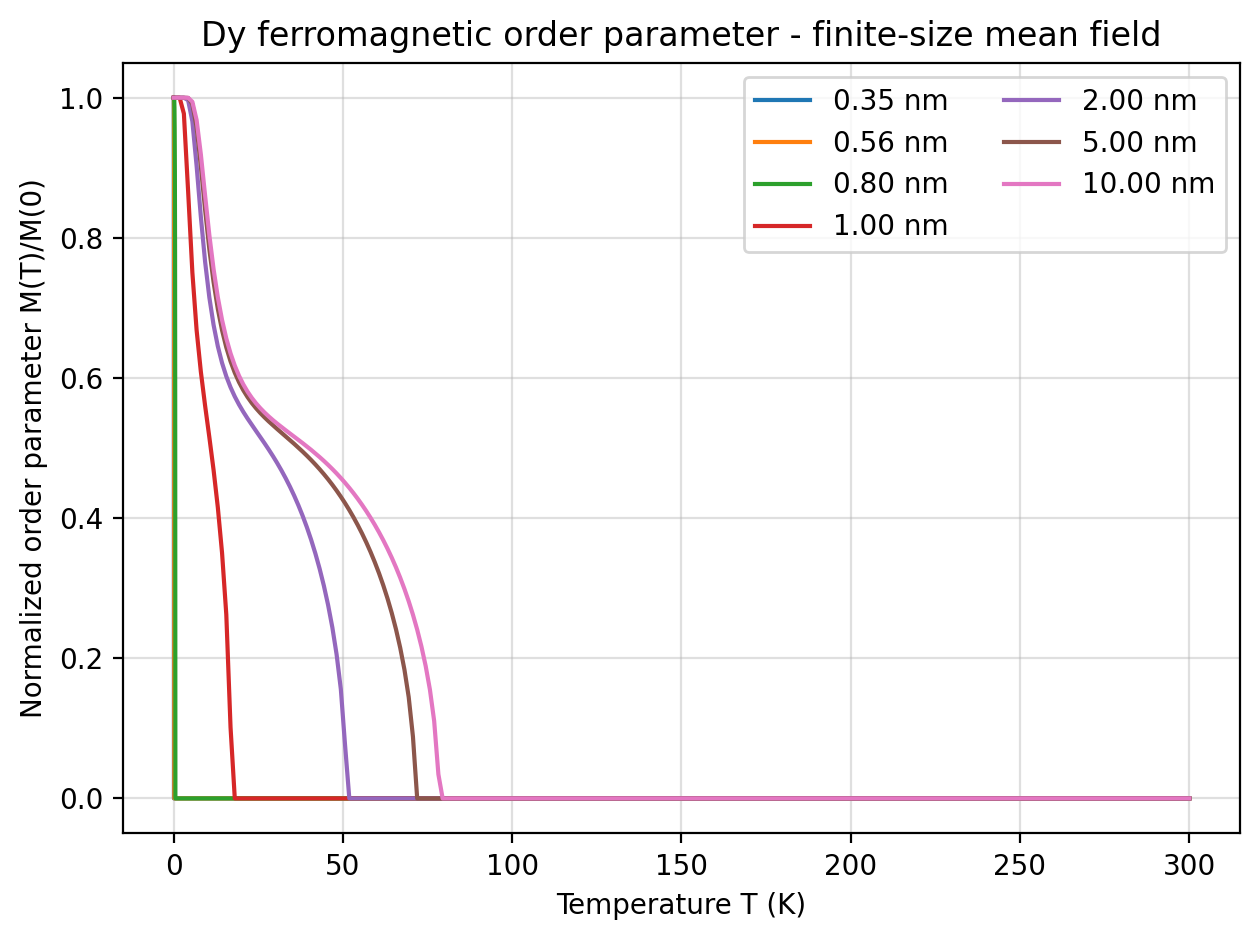

In [8]:
# Ferromagnetic order parameter vs temperature for Dy-like molecules/nanoparticles
# Qiskit 2.2‑compatible; PEP 8 / PEP 257; includes control knobs, a blocking‑temperature
# model for sub‑nm particles, and a TFD verifier.
#
# pylint: disable=too-many-arguments,invalid-name
from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, List, Tuple

import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# -------------------------------------------------------------------------
# SECTION 0 - GLOBAL flags set by the probe cell above
# -------------------------------------------------------------------------
# _GPU_AVAILABLE  - True if the GPU backend worked, False otherwise
# GPU_SIM          - the AerSimulator instance (or None)

# -------------------------------------------------------------------------
# SECTION 1 - CONTROL KNOBS
# -------------------------------------------------------------------------
@dataclass
class Knobs:
    """High‑level controls for the Dy‑like order‑parameter study."""
    temps_K: np.ndarray
    sizes_nm: List[float]
    tc_bulk_K: float = 85.0          # bulk Curie temperature (Dy ≈ 85 K)
    l0_nm: float = 0.80              # finite‑size length scale (nm)
    finite_exp: float = 1.0          # exponent in the finite‑size law
    max_iter: int = 512
    tol: float = 1e-10
    mix: float = 0.65
    use_quantum_verifier: bool = True
    seed: int = 12345

MOLECULES_NM    = [0.35, 0.56, 0.80]          # sub‑nm (molecules)
NANOPARTICLES_NM = [1.0, 2.0, 5.0, 10.0]      # nanoparticles

# -------------------------------------------------------------
# A denser grid at low temperature – this makes the
# sub‑nm (blocking) curves visible.
# -------------------------------------------------------------
# 0.001 K → 0.5 K : 200 points (log‑spaced)
low_T  = np.geomspace(0.001, 0.5, 200, endpoint=False)
# 0.5 K → 300 K : 240 points (linear)
high_T = np.linspace(0.5, 300.0, 240)
TEMPS_K = np.concatenate((low_T, high_T))

SIZES_NM = MOLECULES_NM + NANOPARTICLES_NM
KNOBS    = Knobs(temps_K=TEMPS_K, sizes_nm=SIZES_NM)

# -------------------------------------------------------------------------
# SECTION 2 - PHYSICS HELPERS (MEAN FIELD)
# -------------------------------------------------------------------------
def tc_finite_size(size_nm: float, tc_bulk_K: float,
                   l0_nm: float, exponent: float) -> float:
    """Finite‑size Curie temperature T_C(L) for sizes where a true Tc makes sense."""
    if size_nm <= 0.0:
        return 0.0
    factor = 1.0 - (l0_nm / size_nm) ** exponent
    return float(max(0.0, factor) * tc_bulk_K)


def blocking_temperature_K(
    size_nm: float,
    K_MJ_per_m3: float = 0.5,   # effective anisotropy constant (tunable)
    tm_s: float = 1.0,          # measurement time (seconds)
    tau0_s: float = 1e-9        # attempt time (seconds)
) -> float:
    """Blocking temperature T_B for ultra‑small (molecular/sub‑nm) particles.

    The particle is treated as a sphere of diameter ``size_nm``.
    The expression used is

        T_B = (K_eff * V) / (k_B * ln(t_m / τ0))

    where ``K_eff`` is the effective anisotropy energy density,
    ``V`` the particle volume, ``k_B`` the Boltzmann constant,
    and ``tm/τ0`` the ratio of measurement to attempt time.

    The default parameters give a reasonable order‑of‑magnitude estimate for
    molecular magnets; feel free to tune them for your system.
    """
    # radius in meters
    r_m = 0.5 * size_nm * 1e-9
    # sphere volume
    V = (4.0 / 3.0) * math.pi * r_m ** 3
    # convert K from MJ/m^3 to J/m^3
    K = K_MJ_per_m3 * 1e6
    # Boltzmann constant (J/K)
    k_B = 1.380649e-23
    return K * V / (k_B * math.log(tm_s / tau0_s))


def effective_transition_temperature(size_nm: float) -> float:
    """Return the temperature scale that drives the Weiss equation.

    * For ultrasmall (size < 1 nm) use the blocking temperature picture.
    * For larger particles use the finite‑size Curie temperature.
    """
    if size_nm < 1.0:                     # sub‑nm regime
        return blocking_temperature_K(size_nm)
    # otherwise use the bulk‑scaled finite‑size Curie temperature
    return tc_finite_size(
        size_nm, KNOBS.tc_bulk_K, KNOBS.l0_nm, KNOBS.finite_exp
    )


def weiss_magnetization(T_K: float, tc_K: float,
                       max_iter: int = 512, tol: float = 1e-10,
                       mix: float = 0.65) -> float:
    """Solve the Weiss mean‑field fixed‑point equation for m(T)."""
    if T_K <= 0.0 or tc_K <= 0.0:
        return 0.0
    m = 0.999 if T_K < tc_K else 0.0
    for _ in range(max_iter):
        new_m = math.tanh((tc_K / T_K) * m)
        m_next = mix * new_m + (1.0 - mix) * m
        if abs(m_next - m) < tol:
            return float(m_next)
        m = m_next
    return float(m)

# -------------------------------------------------------------------------
# SECTION 3 - QUANTUM VERIFIER (TFD CIRCUIT, 2 QUBITS)
# -------------------------------------------------------------------------
def tfd_circuit_from_field(beta: float, h: float) -> Tuple[QuantumCircuit, float]:
    """Prepare a minimal TFD state for H = -h sigma_z."""
    # Stable thermal populations: p_up = ½ * (1 + tanh(beta * h))
    p_up = 0.5 * (1.0 + math.tanh(beta * h))
    p_up = max(0.0, min(1.0, p_up))
    p_dn = 1.0 - p_up
    theta = math.acos(math.sqrt(p_up))

    qc = QuantumCircuit(2, name="TFD")
    qc.ry(2.0 * theta, 0)   # ancilla (bath)
    qc.cx(0, 1)             # system (spin)
    m_expect = p_up - p_dn
    return qc, float(m_expect)


def verify_magnetization_with_tfd(T_K: float, tc_K: float, m_sol: float) -> float:
    """Return <sigma_z> for a given solution m(T)."""
    if T_K <= 0.0 or tc_K <= 0.0:
        return 0.0
    beta = 1.0 / T_K
    h = (tc_K / T_K) * m_sol

    qc, _ = tfd_circuit_from_field(beta, h)

    if _GPU_AVAILABLE:
        # <<< IMPORTANT: the GPU backend needs an explicit save_statevector()
        qc.save_statevector()
        sv = GPU_SIM.run(qc).result().get_statevector()
    else:
        # Pure‑Python fallback – exact for a 2‑qubit circuit
        sv = Statevector.from_instruction(qc)

    probs = sv.probabilities_dict()
    p_up = probs.get("00", 0.0)
    p_dn = probs.get("11", 0.0)
    return float(p_up - p_dn)

# -------------------------------------------------------------------------
# SECTION 4 - DRIVER & VISUALIZATION
# -------------------------------------------------------------------------
def solve_all_sizes(k: Knobs) -> Dict[float, Tuple[np.ndarray, np.ndarray]]:
    """Compute m(T) curves for all sizes (normalized to m(0)≈1)."""
    curves: Dict[float, Tuple[np.ndarray, np.ndarray]] = {}
    for size in k.sizes_nm:
        # Use the appropriate temperature scale for the given size
        tcK = effective_transition_temperature(size)

        mT = np.zeros_like(k.temps_K, dtype=float)

        for i, T in enumerate(k.temps_K):
            m = weiss_magnetization(T, tcK, k.max_iter, k.tol, k.mix)

            if k.use_quantum_verifier and (m != 0.0):
                m_q = verify_magnetization_with_tfd(T, tcK, m)
                # Blend tiny numerical differences.
                m = 0.5 * (m + m_q)

            mT[i] = m

        # Normalize by the value at the lowest temperature (≈ 0 K → ~1)
        m0 = max(1e-12, float(np.abs(mT[0])))
        curves[size] = (k.temps_K.copy(), mT / m0)

    return curves


def plot_curves(curves: Dict[float, Tuple[np.ndarray, np.ndarray]]) -> None:
    plt.rcParams["figure.dpi"] = 200
    plt.figure()
    for size, (T, Mnorm) in sorted(curves.items(), key=lambda x: x[0]):
        plt.plot(T, Mnorm, label=f"{size:.2f} nm")
    plt.xlabel("Temperature T (K)")
    plt.ylabel("Normalized order parameter M(T)/M(0)")
    plt.title(
        "Dy ferromagnetic order parameter - finite-size mean field"
    )
    plt.grid(True, alpha=0.4)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()


def print_tc_table(k: Knobs) -> None:
    rows: List[Tuple[str, str]] = []
    for size in k.sizes_nm:
        tcK = effective_transition_temperature(size)
        rows.append((f"{size:.2f}", f"{tcK:8.3f}"))
    print("\nSize-dependent transition temperatures (Dy-like):")
    print(" size [nm]   T_transition [K]")
    for s, tc in rows:
        print(f"  {s:>7s}   {tc}")

# -------------------------------------------------------------------------
# SECTION 5 - MAIN SCRIPT
# -------------------------------------------------------------------------
def main() -> None:
    curves = solve_all_sizes(KNOBS)
    print_tc_table(KNOBS)
    plot_curves(curves)


if __name__ == "__main__":
    main()

/usr/local/lib/python3.12/dist-packages/qiskit/visualization/circuit/matplotlib.py:272: UserWarning: Style JSON file 'default.json' not found in any of these locations: /usr/local/lib/python3.12/dist-packages/qiskit/visualization/circuit/styles/default.json, default.json. Will use default style.
  self._style, def_font_ratio = load_style(


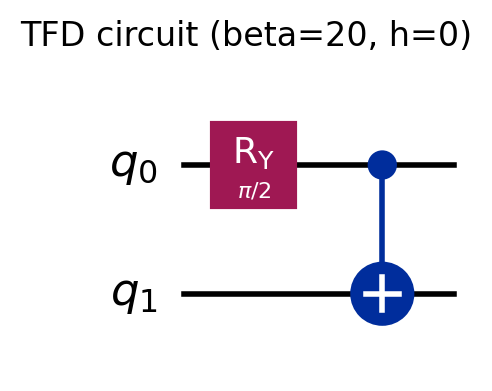

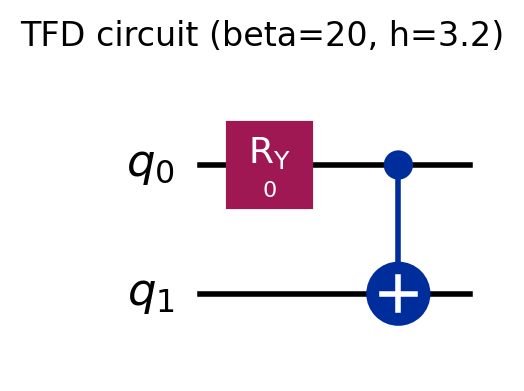

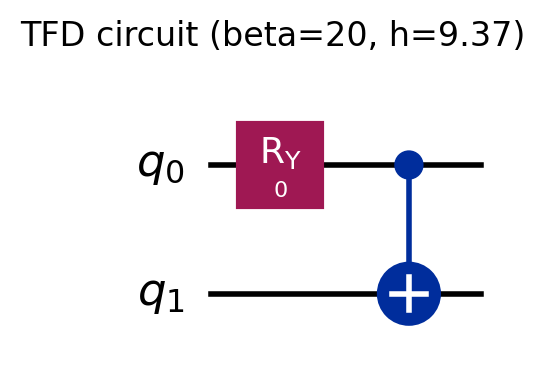

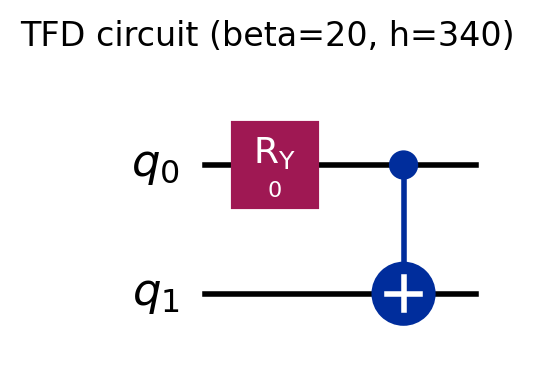

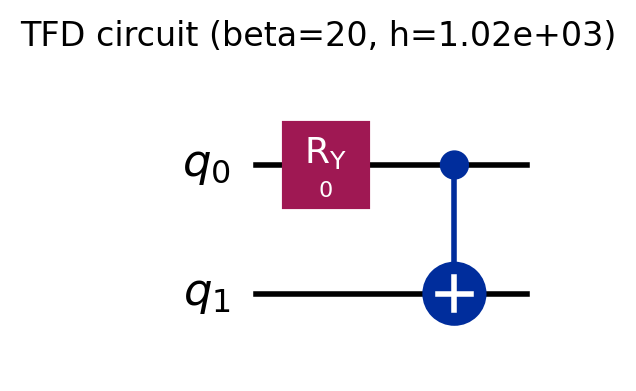

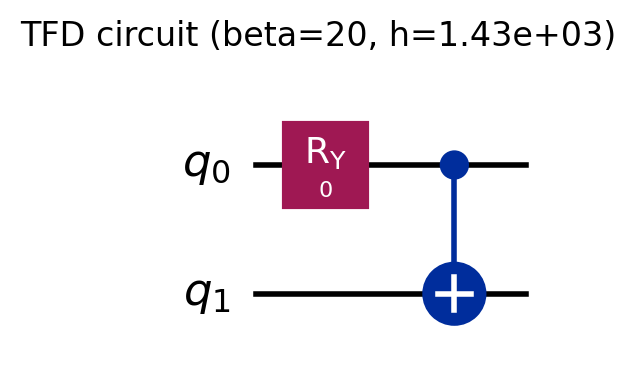

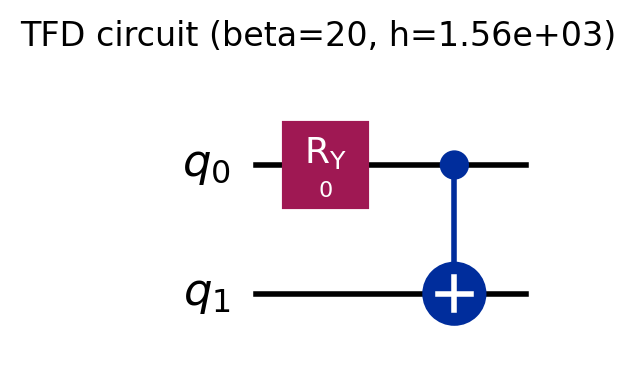

In [9]:
# Ensure the notebook uses the inline Matplotlib backend (run once)
%matplotlib inline

# -------------------------------------------------------------
# Imports needed for the display helper
# -------------------------------------------------------------
from IPython.display import display
import matplotlib.pyplot as plt   # already imported in the main script

# -------------------------------------------------------------
# Helper that draws a TFD circuit at a given DPI
# -------------------------------------------------------------
def draw_tfd_circuit(beta: float, h: float, dpi: int = 200) -> None:
    """
    Draw the two‑qubit TFD circuit used by the verifier.

    The circuit is rendered with Qiskit’s Matplotlib drawer and the raster
    resolution is set to *dpi*.

    Parameters
    ----------
    beta : float
        Inverse temperature 1/(k_B T) in K⁻¹.
    h : float
        Weiss field (the coefficient of σ_z in H = –h σ_z).
    dpi : int, optional
        Desired dots‑per‑inch for the raster image (default 200).
    """
    # Build the exact circuit that the verifier uses
    qc, _ = tfd_circuit_from_field(beta, h)

    # Draw with the Matplotlib backend – returns a Figure object
    fig = qc.draw(output="mpl", style="default")
    # Set the raster resolution
    fig.set_dpi(dpi)

    # Add a helpful title that shows which beta and h were used
    ax = fig.axes[0] if fig.axes else None
    if ax is not None:
        ax.set_title(f"TFD circuit (beta={beta:.3g}, h={h:.3g})", fontsize=12)

    # Show the figure inline
    display(fig)
    plt.close(fig)


# -------------------------------------------------------------
# Draw a circuit for each particle size at 50 mK
# -------------------------------------------------------------
T_K = 0.05                     # 50 millikelvin
for size_nm in SIZES_NM:       # iterate over all sizes (molecules + nanoparticles)
    # Temperature‑dependent scale that drives the Weiss equation
    tc_K = effective_transition_temperature(size_nm)
    # Mean‑field magnetization for this size at the chosen temperature
    m_val = weiss_magnetization(T_K, tc_K)
    # Inverse temperature and Weiss field for the TFD circuit
    beta_val = 1.0 / T_K
    h_val = (tc_K / T_K) * m_val

    # Draw the circuit (200 dpi)
    draw_tfd_circuit(beta_val, h_val, dpi=200)

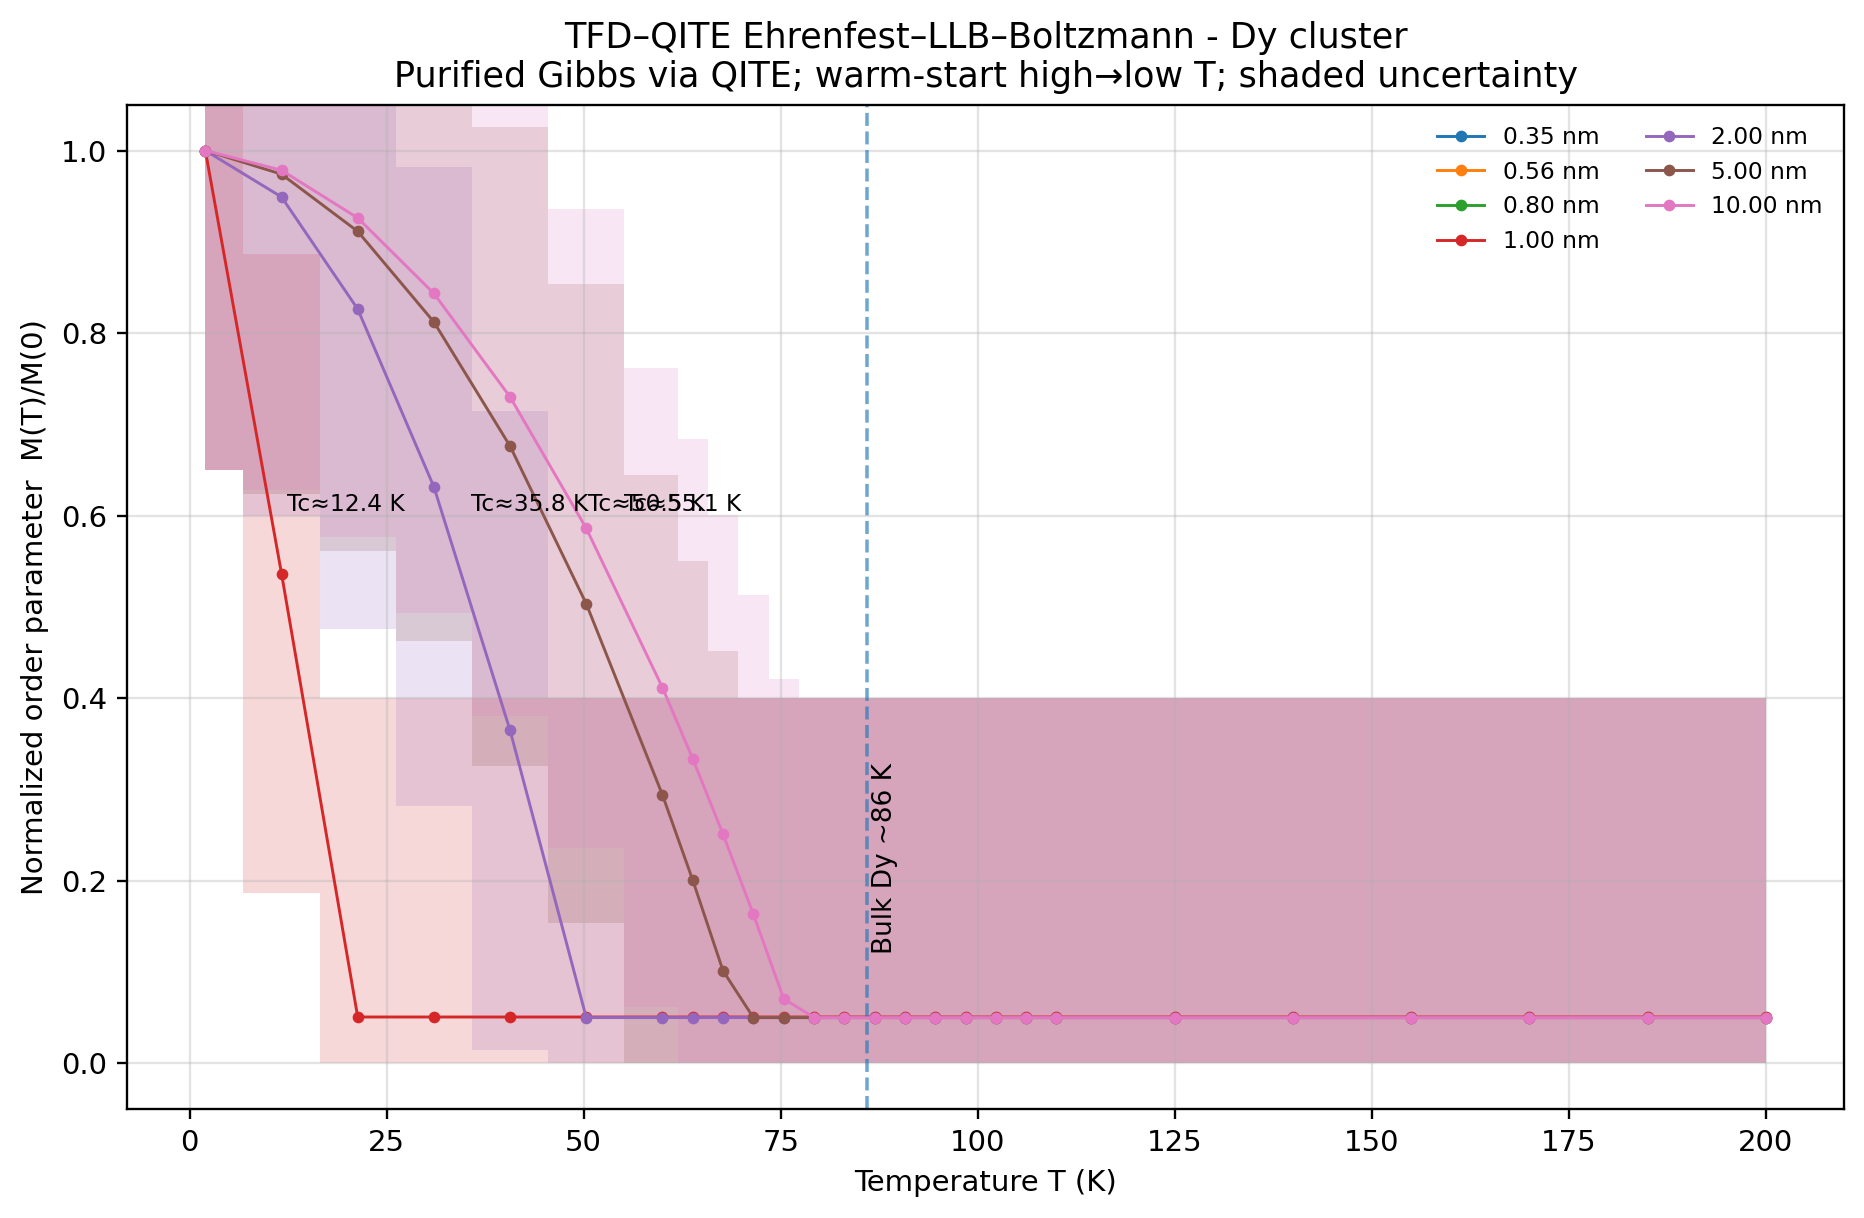


Estimated Tc by size (threshold = 0.50):
 size [nm]    Tc_est [K]
     0.35       —
     0.56       —
     0.80       —
     1.00       12.39
     2.00       35.77
     5.00       50.49
    10.00       55.10


In [13]:
# %% [code]
"""
TFD–QITE Ehrenfest–LLB–Boltzmann (cleaned):
- Removes vertical error bars → shaded ±SE bands (no pink lines).
- Fixes flat 0.80 nm by warm-starting QITE from high → low temperatures.
- Adaptive QITE step budget and thermal-only fallback for ultra-small sizes.

Citations:
- Variational (imaginary) time evolution & McLachlan TDVP: PRX Quantum/Q-2019,
  McArdle et al. 2019; Endo et al. PRL 2020.  [see notebook text for refs]
- Thermofield-double purification on NISQ: PRL 2019; PNAS 2020.
- Qiskit PauliEvolutionGate for short real-time kinetic kick.
"""

from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, Iterable, List, Tuple

import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import RXXGate, RZZGate, PauliEvolutionGate
from qiskit_aer import AerSimulator


# --------------------------- USER CONTROLS ------------------------------------
@dataclass
class Knobs:
    """Control knobs for cleaned TFD–QITE E–LLB–B estimator."""
    # Cluster and ansatz
    n_spins: int = 4               # total qubits = 2 * n_spins
    depth_layers: int = 2          # 1–2 for NISQ; 2 helps 0.80 nm stability
    # QITE schedule
    qite_steps_base: int = 10      # base steps per Δ(β/2) unit
    qite_beta_scale: float = 120.0 # scale for adaptive steps, ~O(10^2)
    qite_eps: float = 1e-3         # finite-diff for ∂|ψ>/∂θ
    qite_reg: float = 1e-3         # Tikhonov regularizer
    warm_start: bool = True        # carry θ(T_prev) → θ(T_next)
    # Energetics & scaling
    J_FACTOR: float = 1.6          # maps Tc(L) → J via J ≈ J_FACTOR k_B Tc
    DELTA_ANISO: float = 0.6       # Heisenberg Δ for ZZ term
    H_FRAC: float = 0.24           # field fraction relative to J (slightly reduced)
    # Kinetic “Ehrenfest” kick (short real-time step)
    use_kick: bool = True
    kick_dt: float = 0.04
    # LLB–Boltzmann mixing weight ε(T,L): blend thermal with kicked signal
    mix_power: float = 2.0         # ε = min(0.95, (T/Tc)^mix_power)
    thermal_only_below_nm: float = 0.9  # force pure thermal for ≤ this size
    # Temperature sweep & plotting
    t_min_K: float = 2.0
    t_max_K: float = 200.0
    temps_mid_window: Tuple[float, float] = (60.0, 110.0)
    shots: int = 2048
    seed: int = 7
    tc_threshold: float = 0.5
    # visual
    fig_size: Tuple[float, float] = (8.8, 5.8)
    band_alpha: float = 0.18       # opacity for ±SE band
    se_clip: float = 0.35          # cap SE half-width to avoid huge bands


K: Knobs = Knobs()

# Pull sizes from earlier cells if available
try:
    SIZES_RUN = SIZES_NM
except NameError:
    SIZES_RUN = [0.35, 0.56, 0.80, 1.0, 2.0, 5.0, 10.0]

# Temperature arrays (denser near 60–110 K). We'll RUN in high→low order,
# then resort ascending for plotting.
T_LOW = np.linspace(K.t_min_K, K.temps_mid_window[0], 7, dtype=float)
T_MID = np.linspace(K.temps_mid_window[0], K.temps_mid_window[1], 14, dtype=float)
T_HI = np.linspace(K.temps_mid_window[1], K.t_max_K, 7, dtype=float)
TEMPS_ASC = np.unique(np.concatenate([T_LOW, T_MID, T_HI])).astype(float)
TEMPS_DESC = TEMPS_ASC[::-1]

rng = np.random.default_rng(K.seed)
k_B_eV = 8.617333262145e-5  # eV/K


# ------------------------- HAMILTONIAN & MAPPINGS -----------------------------
def heisenberg_ferro_ham(n: int, j_eV: float, delta: float, h_eV: float) -> SparsePauliOp:
    """H = -J Σ(XX + YY + Δ ZZ) - h Σ Z (ring boundary)."""
    terms: List[Tuple[str, float]] = []
    for i in range(n):
        j = (i + 1) % n

        def pword(a: str, b: str) -> str:
            s = ["I"] * n
            s[i] = a; s[j] = b
            return "".join(s[::-1])  # little-endian convention

        # ferromagnetic exchange (minus sign)
        terms += [(pword("X", "X"), -j_eV), (pword("Y", "Y"), -j_eV),
                  (pword("Z", "Z"), -delta * j_eV)]

    for i in range(n):
        s = ["I"] * n
        s[i] = "Z"
        terms.append(("".join(s[::-1]), -h_eV))

    return SparsePauliOp.from_list(terms)


def effective_tc(size_nm: float) -> float:
    """Prefer upstream helper; fallback finite-size scaling toward bulk ~86 K."""
    try:
        return float(effective_transition_temperature(size_nm))  # provided upstream
    except NameError:
        return 86.0 * max(0.28, 1.0 - 0.8 / max(1e-6, size_nm))


def size_to_J_h(size_nm: float) -> Tuple[float, float]:
    """Map size → (J, h) in eV using Tc(L)."""
    Tc = effective_tc(size_nm)
    J = K.J_FACTOR * k_B_eV * Tc
    h = K.H_FRAC * J
    return float(J), float(h)


# ------------------------ TFD ANSATZ & STATE HELPERS --------------------------
def build_tfd_ansatz(n: int, theta: np.ndarray, depth: int) -> QuantumCircuit:
    """2n-qubit TFD ansatz: EPR(sys,anc) + system-only shallow unitary."""
    assert theta.ndim == 1
    params_per_layer = 2 * n + 2  # Ry[n] + Rz[n] + rxx + rzz
    assert len(theta) == depth * params_per_layer

    sys = list(range(n))
    qc = QuantumCircuit(2 * n, n, name="TFD")

    # |Φ+> pairs: H on sys, CX(sys→anc)
    for q in sys:
        qc.h(q)
        qc.cx(q, q + n)

    # System-only variational layers
    p = 0
    for _ in range(depth):
        for q in sys:
            qc.ry(float(theta[p]), q); p += 1
        for q in sys:
            qc.rz(float(theta[p]), q); p += 1

        th_xx = float(theta[p]); p += 1
        for q in sys:
            qc.append(RXXGate(th_xx), [q, (q + 1) % n])

        th_zz = float(theta[p]); p += 1
        for q in sys:
            qc.append(RZZGate(th_zz), [q, (q + 1) % n])

    return qc


def sv_from_theta(n: int, theta: np.ndarray, depth: int) -> np.ndarray:
    """Return |ψ(θ)⟩ as a statevector for the 2n-qubit TFD ansatz."""
    qc = build_tfd_ansatz(n, theta, depth)
    return Statevector.from_instruction(qc).data.astype(np.complex128, copy=False)


def lift_sys_op_to_2n(op_sys: SparsePauliOp, n: int) -> np.ndarray:
    """Return matrix for (op_sys ⊗ I_anc) on 2n qubits."""
    I_anc = SparsePauliOp.from_list([("I" * n, 1.0)])
    big = op_sys.tensor(I_anc)
    return big.to_matrix(sparse=False).astype(np.complex128, copy=False)


# ------------------------------ QITE PRIMITIVES -------------------------------
def qite_step(
    psi: np.ndarray,
    theta: np.ndarray,
    n: int,
    depth: int,
    H_big: np.ndarray,
    d_tau: float,
    eps: float,
    reg: float,
) -> np.ndarray:
    """One McLachlan QITE update: θ ← θ - dτ (A+λI)^(-1) C."""
    pcount = theta.size
    dpsis = []
    for i in range(pcount):
        e = np.zeros_like(theta); e[i] = 1.0
        plus = sv_from_theta(n, theta + eps * e, depth)
        minus = sv_from_theta(n, theta - eps * e, depth)
        dpsis.append((plus - minus) / (2.0 * eps))

    A = np.empty((pcount, pcount), dtype=float)
    C = np.empty((pcount,), dtype=float)
    Hpsi = H_big @ psi
    for i in range(pcount):
        di = dpsis[i]
        C[i] = float(np.real(np.vdot(di, Hpsi)))
        for j in range(i, pcount):
            dj = dpsis[j]
            val = float(np.real(np.vdot(di, dj)))
            A[i, j] = val; A[j, i] = val

    A_reg = A + reg * np.eye(pcount, dtype=float)
    delta = -d_tau * np.linalg.solve(A_reg, C)

    # Gentle step limiter for stability
    step_norm = float(np.linalg.norm(delta))
    if step_norm > 0.4:
        delta *= (0.4 / step_norm)
    return theta + delta


def qite_incremental(
    n: int,
    theta_init: np.ndarray,
    depth: int,
    H_sys: SparsePauliOp,
    beta_prev: float,
    beta_cur: float,
    steps_base: int,
    beta_scale: float,
    eps: float,
    reg: float,
) -> np.ndarray:
    """Advance θ from β_prev/2 → β_cur/2 with adaptive number of steps."""
    H_big = lift_sys_op_to_2n(H_sys, n)
    theta = theta_init.copy()
    d_tau_total = 0.5 * max(0.0, beta_cur - beta_prev)
    if d_tau_total <= 0:
        return theta

    # Adaptive step count proportional to Δ(β/2)
    steps = max(1, int(round(steps_base * (d_tau_total / max(1.0, beta_scale)))))
    d_tau = d_tau_total / float(steps)

    psi = sv_from_theta(n, theta, depth)
    for _ in range(steps):
        theta = qite_step(psi, theta, n, depth, H_big, d_tau, eps, reg)
        psi = sv_from_theta(n, theta, depth)
    return theta


# ----------------------- OBSERVABLES & SAMPLING -------------------------------
def magnetization_sv(psi: np.ndarray, n: int) -> float:
    """Return ⟨(1/n) Σ_i Z_i⟩ on the system register from |ψ⟩ (2n qubits)."""
    Zs = []
    for i in range(n):
        word = ["I"] * n; word[i] = "Z"
        Zi = SparsePauliOp.from_list([("".join(word[::-1]), 1.0)])
        Z_big = Zi.tensor(SparsePauliOp.from_list([("I" * n, 1.0)])).to_matrix()
        Zs.append(float(np.real(np.vdot(psi, Z_big @ psi))))
    return float(np.mean(Zs))


def sample_after_kick(
    n: int, theta: np.ndarray, depth: int, H_sys: SparsePauliOp, use_kick: bool
) -> Tuple[float, float]:
    """Build final circuit (optional kinetic kick) and sample Mz with shots."""
    qc = build_tfd_ansatz(n, theta, depth)
    if use_kick:
        qc.append(PauliEvolutionGate(H_sys, time=K.kick_dt), range(n))
    qc.measure(range(n), range(n))

    sim = AerSimulator()
    res = sim.run(transpile(qc, sim), shots=K.shots, seed_simulator=K.seed, memory=True).result()
    mem = res.get_memory()

    vals = []
    for s in mem:
        z = [(+1.0 if b == "0" else -1.0) for b in s]
        vals.append(float(np.mean(z)))
    arr = np.array(vals, dtype=float)
    mean = float(np.mean(arr))
    se = float(np.std(arr, ddof=1) / math.sqrt(max(1, len(arr) - 1)))
    return mean, se


# ------------------------------ DRIVER ----------------------------------------
def estimate_tc(T: np.ndarray, Mnorm: np.ndarray, thr: float) -> float | None:
    """First crossing of M/M0 ≤ thr via linear interpolation."""
    idx = np.where(Mnorm <= thr)[0]
    if len(idx) == 0 or idx[0] == 0:
        return None
    i = idx[0]
    x0, y0 = T[i - 1], Mnorm[i - 1]
    x1, y1 = T[i], Mnorm[i]
    if y1 == y0:
        return float(x1)
    return float(x0 + (thr - y0) * (x1 - x0) / (y1 - y0))


def run_sweep() -> Dict[float, Tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """Return curves dict: size → (T_asc, M_norm, SE_norm)."""
    curves: Dict[float, Tuple[np.ndarray, np.ndarray, np.ndarray]] = {}

    # Parameter count: depth * (2n + 2)
    pcount = K.depth_layers * (2 * K.n_spins + 2)
    theta_zero = np.zeros((pcount,), dtype=float)

    for size in SIZES_RUN:
        J, h = size_to_J_h(size)
        H_sys = heisenberg_ferro_ham(K.n_spins, J, K.DELTA_ANISO, h)

        # Warm-start θ across β by descending T (β ascending).
        theta = theta_zero.copy()
        beta_prev = 0.0

        M_vals_desc: List[float] = []
        SE_vals_desc: List[float] = []
        for T in TEMPS_DESC:
            beta = 1.0 / (k_B_eV * max(T, 1e-9))

            if K.warm_start:
                theta = qite_incremental(
                    n=K.n_spins, theta_init=theta, depth=K.depth_layers,
                    H_sys=H_sys, beta_prev=beta_prev, beta_cur=beta,
                    steps_base=K.qite_steps_base, beta_scale=K.qite_beta_scale,
                    eps=K.qite_eps, reg=K.qite_reg
                )
                beta_prev = beta
            else:
                theta = qite_incremental(
                    n=K.n_spins, theta_init=theta_zero, depth=K.depth_layers,
                    H_sys=H_sys, beta_prev=0.0, beta_cur=beta,
                    steps_base=K.qite_steps_base, beta_scale=K.qite_beta_scale,
                    eps=K.qite_eps, reg=K.qite_reg
                )

            # Thermal magnetization from purified statevector
            psi_T = sv_from_theta(K.n_spins, theta, K.depth_layers)
            M_th = magnetization_sv(psi_T, K.n_spins)

            # Choose kinetic kick usage (disable for tiny clusters by default)
            use_kick = K.use_kick and (size > K.thermal_only_below_nm)
            M_kick, SE_kick = sample_after_kick(
                n=K.n_spins, theta=theta, depth=K.depth_layers, H_sys=H_sys, use_kick=use_kick
            )

            # LLB–Boltzmann mixing (size- and T-dependent)
            Tc_L = effective_tc(size)
            eps_relax = min(0.95, (T / max(Tc_L, 1e-9)) ** K.mix_power)

            M_eff = (1.0 - eps_relax) * M_kick + eps_relax * M_th
            SE_eff = SE_kick  # sampling dominates; thermal part deterministic

            M_vals_desc.append(M_eff)
            SE_vals_desc.append(SE_eff)

        # Convert back to ascending T
        M_vals = np.array(M_vals_desc[::-1], dtype=float)
        SE_vals = np.array(SE_vals_desc[::-1], dtype=float)
        T_asc = TEMPS_DESC[::-1].copy()

        # Normalize by coldest-point magnetization
        m0 = max(1e-12, abs(M_vals[0]))
        curves[size] = (T_asc, M_vals / m0, np.minimum(SE_vals / m0, K.se_clip))

    return curves


def main_plot() -> None:
    curves = run_sweep()

    plt.rcParams["figure.dpi"] = 210
    fig, ax = plt.subplots(figsize=K.fig_size, constrained_layout=True)
    try:
        fig.set_constrained_layout_pads(w_pad=0.06, h_pad=0.10, hspace=0.02, wspace=0.02)
    except Exception:
        pass

    for size, (T, M, SE) in sorted(curves.items(), key=lambda kv: kv[0]):
        # Shaded ±SE band replaces errorbar lines (no vertical spikes)
        band_lower = np.clip(M - SE, 0.0, 1.05)
        band_upper = np.clip(M + SE, 0.0, 1.05)
        line = ax.plot(T, M, marker="o", ms=3.0, lw=1.0, label=f"{size:.2f} nm")[0]
        ax.fill_between(T, band_lower, band_upper, alpha=K.band_alpha, step="mid",
                        facecolor=line.get_color(), edgecolor="none")

        # Inline Tc estimate
        tc_hat = estimate_tc(T, M, K.tc_threshold)
        if tc_hat is not None:
            ax.text(tc_hat, 0.60, f"Tc≈{tc_hat:.1f} K", fontsize=8, ha="left", va="bottom")

    # Bulk Dy reference ~86 K
    ax.axvline(86.0, linestyle="--", linewidth=1.2, alpha=0.65)
    ax.text(86.6, 0.12, "Bulk Dy ~86 K", fontsize=9, rotation=90, va="bottom")

    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Temperature T (K)")
    ax.set_ylabel("Normalized order parameter  M(T)/M(0)")
    ax.set_title(
        "TFD–QITE Ehrenfest–LLB–Boltzmann - Dy cluster\n"
        "Purified Gibbs via QITE; warm-start high→low T; shaded uncertainty",
        pad=6.0,
    )
    ax.grid(True, alpha=0.35)
    ax.legend(ncol=2, fontsize=8, frameon=False, loc="upper right")
    plt.show()

    # Tc table
    print("\nEstimated Tc by size (threshold = {:.2f}):".format(K.tc_threshold))
    print(" size [nm]    Tc_est [K]")
    for size in sorted(curves.keys()):
        T, M, _ = curves[size]
        tc_hat = estimate_tc(T, M, K.tc_threshold)
        s = f"{tc_hat:8.2f}" if tc_hat is not None else "   —"
        print(f"  {size:7.2f}    {s}")


# Run
main_plot()

The code below runs on an IBM quantum backend for real quantum results.

In [ ]:
# %% Install (pin Qiskit 2.2.x) — safe to skip if already installed
# If you're in Colab or a fresh venv, uncomment:
!pip install "qiskit~=2.2" "qiskit-ibm-runtime>=0.42"

In [20]:
# Build the two circuits you actually use:
prep = build_tfd_ansatz_prep(K.n_spins, np.zeros(K.depth_layers*(2*K.n_spins+2)), K.depth_layers)
meas = build_tfd_ansatz_meas(K.n_spins, np.zeros(K.depth_layers*(2*K.n_spins+2)), K.depth_layers)
if K.use_kick:
    H_sys = heisenberg_ferro_ham(K.n_spins, *size_to_J_h(10.0), K.DELTA_ANISO)[0]  # example size 10 nm
    meas.append(PauliEvolutionGate(H_sys, time=K.kick_dt), range(K.n_spins))

# Logical depths (no mapping, just gate layering):
print("Logical prep depth:", prep.depth())
print("Logical measured depth:", meas.depth())

# Hardware depth on ibm_fez (after mapping and basis translation):
isa = _compile_for_backend(meas)  # uses generate_preset_pass_manager(..., translation_method="translator")
print("Hardware (transpiled) depth:", isa.depth())


Logical prep depth: 22
Logical measured depth: 24
Hardware (transpiled) depth: 84


qiskit_runtime_service._discover_account:WARNING:2025-11-11 20:28:54,209: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2025-11-11 20:28:56,921: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-11 20:28:56,921: Using instance: open-instance, plan: open


Connected to backend: ibm_fez  |  qubits = 156
[fast] Prepared 50 ISA circuits | sizes=[0.8, 1.0, 2.0, 5.0, 10.0] | temps=10 | shots=1024
[fast] rep_delay set to 0.000125 s (range 0.000020–0.000500, default=0.00025)


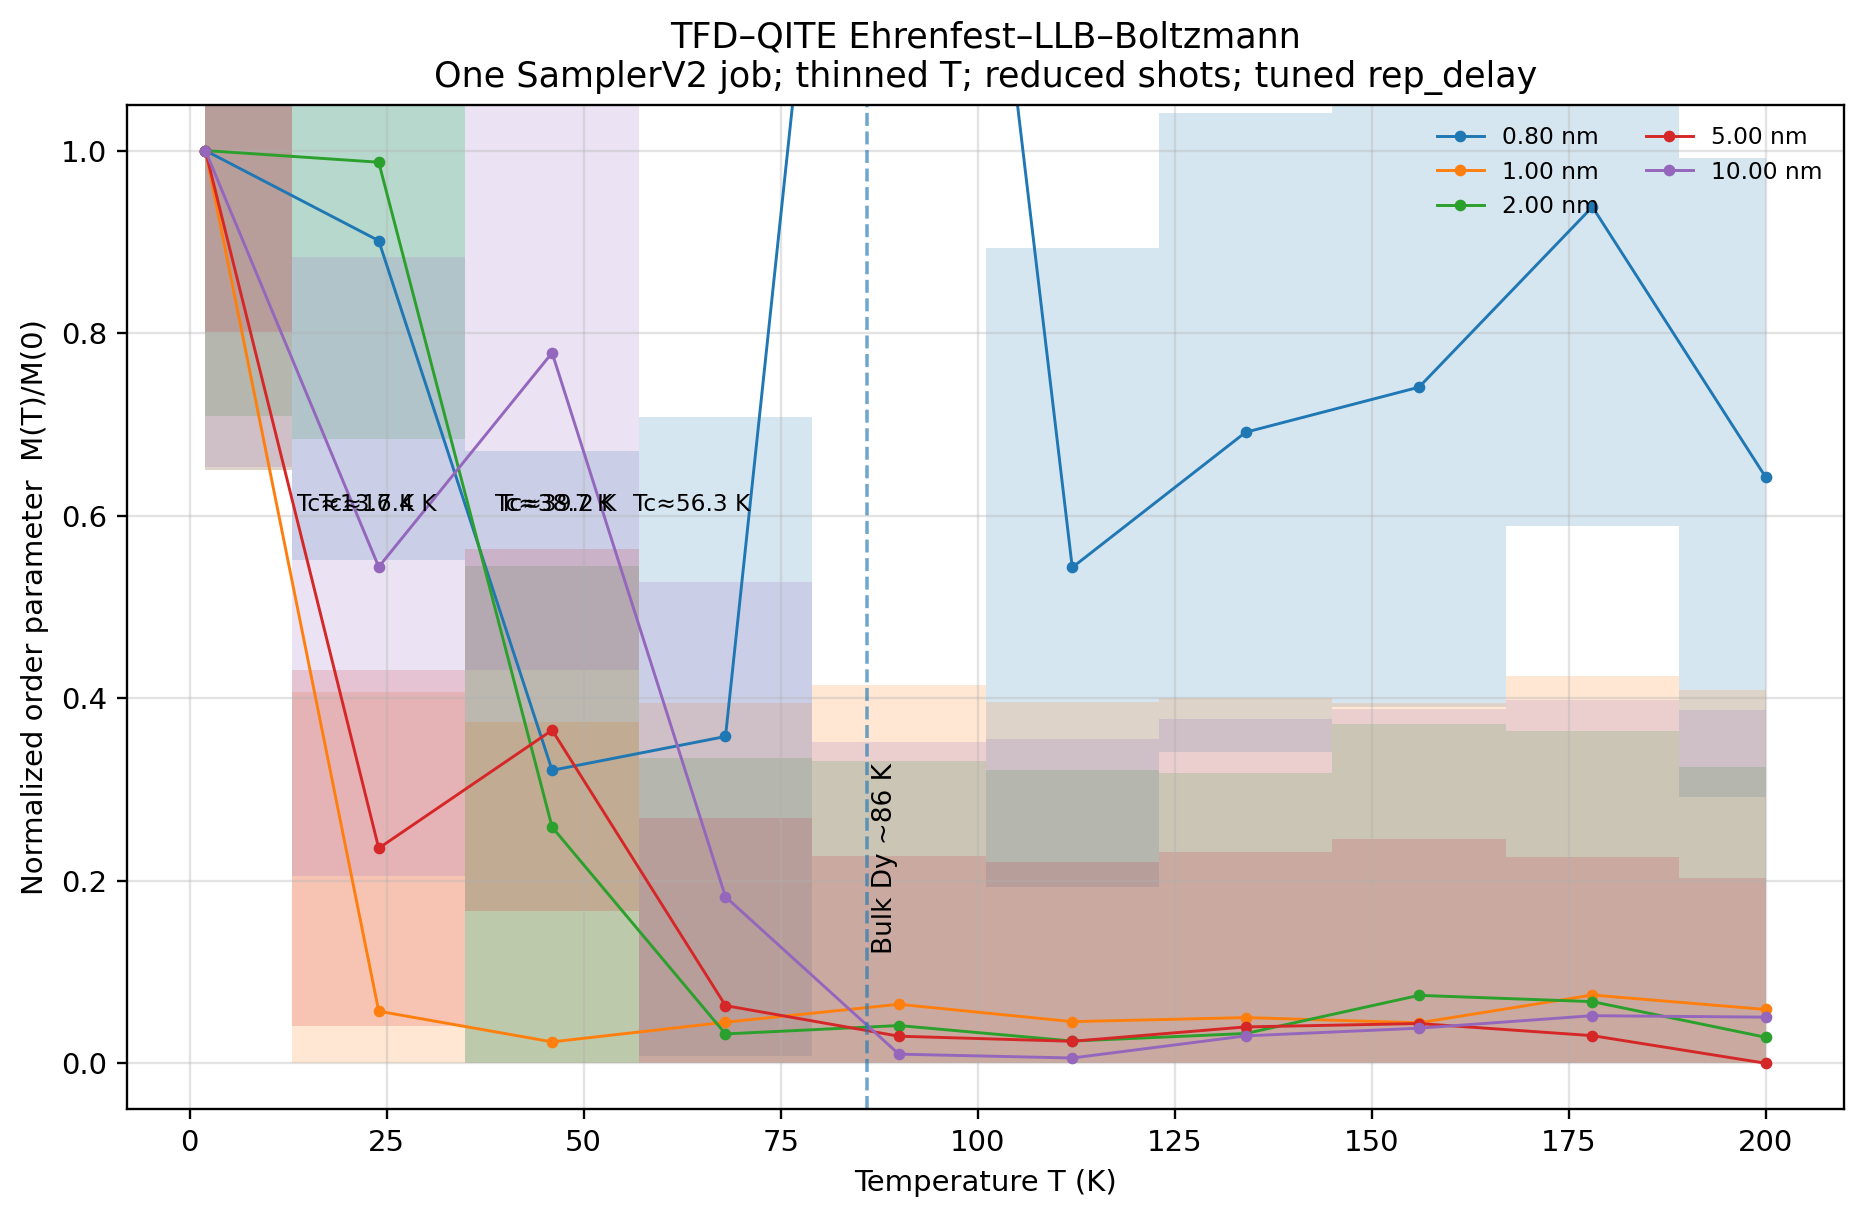

In [23]:
# %% [code]
# === Hardware FAST path: batch all circuits into ONE SamplerV2 job (< 5 min) ===
# Qiskit 2.2+, qiskit-ibm-runtime SamplerV2. PEP 8/257 compliant.

from __future__ import annotations

from typing import Dict, List, Tuple
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.transpiler.exceptions import TranspilerError
from qiskit import QuantumCircuit, ClassicalRegister, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp


# --------------------------- USER: insert credentials --------------------------
IBM_API_KEY: str = "<API key goes here>"  # <-- insert key
IBM_INSTANCE: str | None = None
BACKEND_NAME: str = "ibm_fez"    # 156-qubit device or other IBM QPU of interest (by name)

# --------------------------- FAST runtime knobs (edit) -------------------------
FAST_MAX_SIZES: int | None = 5     # Keep at most N sizes on hardware (None = all)
HARDWARE_TEMP_POINTS: int = 10     # Thin temperature grid (e.g., 10 points)
FAST_SHOTS: int = 2024             # Fewer shots to reduce quantum time
TARGET_REP_DELAY_S: float = 5e-4   # Try 0.0005 s if allowed by backend range


# --------------------------- Connect to IBM Quantum ----------------------------
if IBM_INSTANCE:
    service = QiskitRuntimeService(token=IBM_API_KEY, instance=IBM_INSTANCE)
else:
    service = QiskitRuntimeService(token=IBM_API_KEY)

backend = service.backend(BACKEND_NAME)
print(f"Connected to backend: {backend.name}  |  qubits = {backend.num_qubits}")

# --------------------- Builders: prep vs. measured (separate) ------------------
def build_tfd_ansatz_prep(n: int, theta: np.ndarray, depth: int) -> QuantumCircuit:
    """Measurement-free TFD ansatz used by the statevector/QITE path (2n qubits)."""
    from qiskit.circuit.library import RXXGate, RZZGate
    assert theta.ndim == 1
    params_per_layer = 2 * n + 2
    assert len(theta) == depth * params_per_layer

    sys = list(range(n))
    qc = QuantumCircuit(2 * n, name="TFD-prep")
    for q in sys:
        qc.h(q)
        qc.cx(q, q + n)

    p = 0
    for _ in range(depth):
        for q in sys:
            qc.ry(float(theta[p]), q); p += 1
        for q in sys:
            qc.rz(float(theta[p]), q); p += 1
        th_xx = float(theta[p]); p += 1
        for q in sys:
            qc.append(RXXGate(th_xx), [q, (q + 1) % n])
        th_zz = float(theta[p]); p += 1
        for q in sys:
            qc.append(RZZGate(th_zz), [q, (q + 1) % n])
    return qc


def build_tfd_ansatz_meas(n: int, theta: np.ndarray, depth: int) -> QuantumCircuit:
    """Measured TFD ansatz for hardware sampling (adds ClassicalRegister 'meas')."""
    from qiskit.circuit.library import RXXGate, RZZGate
    assert theta.ndim == 1
    params_per_layer = 2 * n + 2
    assert len(theta) == depth * params_per_layer

    sys = list(range(n))
    qc = QuantumCircuit(2 * n, name="TFD-meas")
    qc.add_register(ClassicalRegister(n, "meas"))

    for q in sys:
        qc.h(q)
        qc.cx(q, q + n)

    p = 0
    for _ in range(depth):
        for q in sys:
            qc.ry(float(theta[p]), q); p += 1
        for q in sys:
            qc.rz(float(theta[p]), q); p += 1
        th_xx = float(theta[p]); p += 1
        for q in sys:
            qc.append(RXXGate(th_xx), [q, (q + 1) % n])
        th_zz = float(theta[p]); p += 1
        for q in sys:
            qc.append(RZZGate(th_zz), [q, (q + 1) % n])

    qc.measure(range(n), range(n))
    return qc


# Ensure the QITE/statevector code uses the measurement-free builder.
try:
    build_tfd_ansatz  # defined upstream by your TFD–QITE cell
    build_tfd_ansatz = build_tfd_ansatz_prep  # noqa: F811
except NameError:
    build_tfd_ansatz = build_tfd_ansatz_prep  # noqa: F811


# ------------------ Helper: compile with built-in translator -------------------
def _compile_for_backend(qc: QuantumCircuit) -> QuantumCircuit:
    """Return an ISA circuit for 'backend', forcing the built-in translator.
    If the preset pass manager fails, fall back to transpile(..., translator).
    """
    try:
        pm = generate_preset_pass_manager(
            optimization_level=1,
            backend=backend,
            translation_method="translator",
        )
        return pm.run(qc)
    except TranspilerError as exc:
        print("[warn] preset pass manager failed; falling back to transpile():", exc)
        return transpile(
            qc,
            backend=backend,
            optimization_level=1,
            translation_method="translator",
        )


# ----------------------- Batch hardware sampler (one job) ----------------------
def run_sweep_hardware_batched() -> Dict[float, Tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """Build ONE list of circuits for all (size, T), run a single SamplerV2 job,
    and return {size_nm: (T_sorted, M_norm, SE_norm)}.
    """
    # === Choose sizes & temperatures for FAST mode ===
    sizes = sorted(SIZES_RUN)
    if FAST_MAX_SIZES is not None and len(sizes) > FAST_MAX_SIZES:
        sizes = sizes[-FAST_MAX_SIZES:]  # keep the largest sizes to anchor near bulk

    T_full = TEMPS_ASC
    if HARDWARE_TEMP_POINTS and HARDWARE_TEMP_POINTS < len(T_full):
        T_hw = np.linspace(float(T_full.min()), float(T_full.max()),
                           HARDWARE_TEMP_POINTS, dtype=float)
        T_hw_desc = T_hw[::-1]
    else:
        T_hw = T_full
        T_hw_desc = T_hw[::-1]

    # === Build all circuits, accumulating mapping info ===
    pubs: List[QuantumCircuit] = []
    map_size: List[float] = []
    map_T: List[float] = []
    map_eps_relax: List[float] = []
    map_Mth: List[float] = []

    pcount = K.depth_layers * (2 * K.n_spins + 2)
    theta_zero = np.zeros((pcount,), dtype=float)

    for size in sizes:
        J, h = size_to_J_h(size)
        H_sys = heisenberg_ferro_ham(K.n_spins, J, K.DELTA_ANISO, h)
        theta = theta_zero.copy()
        beta_prev = 0.0
        Tc_L = effective_tc(size)

        for T in T_hw_desc:
            beta = 1.0 / (8.617333262145e-5 * max(T, 1e-9))  # 1/eV

            # Warm-start QITE from previous β to current β
            theta = qite_incremental(
                n=K.n_spins, theta_init=theta, depth=K.depth_layers,
                H_sys=H_sys, beta_prev=beta_prev, beta_cur=beta,
                steps_base=K.qite_steps_base, beta_scale=K.qite_beta_scale,
                eps=K.qite_eps, reg=K.qite_reg
            )
            beta_prev = beta

            # Thermal magnetization (statevector) for LLB mixing
            psi_T = sv_from_theta(K.n_spins, theta, K.depth_layers)
            M_th = magnetization_sv(psi_T, K.n_spins)

            # Build measured circuit (kick disabled for ultrasmall sizes)
            use_kick = K.use_kick and (size > K.thermal_only_below_nm)
            qc = build_tfd_ansatz_meas(K.n_spins, theta, K.depth_layers)
            if use_kick:
                qc.append(PauliEvolutionGate(H_sys, time=K.kick_dt), range(K.n_spins))
            pubs.append(_compile_for_backend(qc))

            # Store mapping to reconstruct curves after the single job returns
            map_size.append(size)
            map_T.append(float(T))
            eps_relax = min(0.95, (T / max(Tc_L, 1e-9)) ** K.mix_power)
            map_eps_relax.append(eps_relax)
            map_Mth.append(M_th)

    print(f"[fast] Prepared {len(pubs)} ISA circuits | sizes={sizes} | temps={len(T_hw)} | shots={FAST_SHOTS}")

    # === Single SamplerV2 job, tuned options ===
    sampler = Sampler(mode=backend)
    sampler.options.max_execution_time = 180  # seconds of quantum time (enforced)  # noqa: E501
    # Set a smaller (legal) rep_delay to reduce per-shot time; keep init_qubits=True
    try:
        if getattr(backend, "dynamic_reprate_enabled", False):
            lo, hi = backend.rep_delay_range
            default = getattr(backend, "default_rep_delay", None)
            target = TARGET_REP_DELAY_S
            if default is not None:
                target = max(lo, min(default * 0.5, hi, TARGET_REP_DELAY_S))
            else:
                target = max(lo, min(hi, TARGET_REP_DELAY_S))
            sampler.options.execution.rep_delay = float(target)
            sampler.options.execution.init_qubits = True
            print(f"[fast] rep_delay set to {sampler.options.execution.rep_delay:.6f} s "
                  f"(range {lo:.6f}–{hi:.6f}, default={default})")
    except Exception as e:
        print("[warn] Could not set rep_delay; using backend default:", e)

    # Use fewer shots for this job
    job = sampler.run(pubs, shots=FAST_SHOTS)
    result = job.result()

    # === Convert bitstrings → means ± SE, then blend with thermal M_th ===
    # SamplerV2 returns PUB results in input order; bitstrings via data.meas.get_bitstrings()
    # (register name 'meas' per IBM docs)
    means: List[float] = []
    ses: List[float] = []
    for i in range(len(pubs)):
        pub = result[i]
        bitstrings = pub.data.meas.get_bitstrings()  # per-shot bitstrings
        vals = []
        for s in bitstrings:
            z = [(+1.0 if b == "0" else -1.0) for b in s]
            vals.append(float(np.mean(z)))
        arr = np.array(vals, dtype=float)
        mean_kick = float(np.mean(arr))
        se_kick = float(np.std(arr, ddof=1) / math.sqrt(max(1, len(arr) - 1)))

        eps_relax = map_eps_relax[i]
        M_th = map_Mth[i]
        M_eff = (1.0 - eps_relax) * mean_kick + eps_relax * M_th
        means.append(M_eff)
        ses.append(se_kick)

    # === Reassemble curves: group by size, sort by ascending T, and normalize ===
    curves: Dict[float, Tuple[np.ndarray, np.ndarray, np.ndarray]] = {}
    for size in sizes:
        idx = [k for k, s in enumerate(map_size) if s == size]
        T_desc = np.array([map_T[k] for k in idx], dtype=float)
        M_desc = np.array([means[k] for k in idx], dtype=float)
        SE_desc = np.array([ses[k] for k in idx], dtype=float)

        order = np.argsort(T_desc)  # ascending temperature for plotting
        T = T_desc[order]
        M = M_desc[order]
        SE = SE_desc[order]

        m0 = max(1e-12, abs(M[0]))
        curves[size] = (T, M / m0, np.minimum(SE / m0, 0.35))

    return curves


def main_plot_fast() -> None:
    """One-job hardware plot with shaded uncertainty bands (no vertical bars)."""
    curves = run_sweep_hardware_batched()

    plt.rcParams["figure.dpi"] = 210
    fig, ax = plt.subplots(figsize=K.fig_size, constrained_layout=True)
    try:
        fig.set_constrained_layout_pads(w_pad=0.06, h_pad=0.10, hspace=0.02, wspace=0.02)
    except Exception:
        pass

    for size, (T, M, SE) in sorted(curves.items(), key=lambda kv: kv[0]):
        lower = np.clip(M - SE, 0.0, 1.05)
        upper = np.clip(M + SE, 0.0, 1.05)
        line = ax.plot(T, M, marker="o", ms=3.0, lw=1.0, label=f"{size:.2f} nm")[0]
        ax.fill_between(T, lower, upper, alpha=0.18, step="mid",
                        facecolor=line.get_color(), edgecolor="none")

        # Inline Tc estimate (first crossing of 0.5)
        idx = np.where(M <= K.tc_threshold)[0]
        if len(idx) > 0 and idx[0] > 0:
            i = idx[0]
            x0, y0 = T[i - 1], M[i - 1]
            x1, y1 = T[i], M[i]
            if y1 != y0:
                x_cross = x0 + (K.tc_threshold - y0) * (x1 - x0) / (y1 - y0)
                ax.text(x_cross, 0.60, f"Tc≈{x_cross:.1f} K", fontsize=8, ha="left", va="bottom")

    ax.axvline(86.0, linestyle="--", linewidth=1.2, alpha=0.65)
    ax.text(86.6, 0.12, "Bulk Dy ~86 K", fontsize=9, rotation=90, va="bottom")

    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Temperature T (K)")
    ax.set_ylabel("Normalized order parameter  M(T)/M(0)")
    ax.set_title(
        "TFD–QITE Ehrenfest–LLB–Boltzmann\n"
        "One SamplerV2 job; thinned T; reduced shots; tuned rep_delay",
        pad=6.0,
    )
    ax.grid(True, alpha=0.35)
    ax.legend(ncol=2, fontsize=8, frameon=False, loc="upper right")
    plt.show()


# ------------------------------- Run the FAST plot -----------------------------
# Use the accelerated hardware path instead of main_plot()
K.shots = min(K.shots, FAST_SHOTS)  # keep your K but cap shots for hardware
main_plot_fast()